## Prepare corpus

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="2";  

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [6]:
from conlleval import evaluate

In [38]:
from ner_utils import *

In [8]:
initialize_random_seeds()

# Data Prep

## Word Data

In [9]:
x = pd.read_csv('joint_corpus_with_pos.csv')

### Words

In [10]:
sents = x.groupby('sent')[['corpus_form', 'POS_CONC', 'NER']].apply(lambda x: x.values.tolist())
sents[:5]

sent
1    [[נראה, VB, O], [שאביטל, REL|NNP, I_PERS], [אב...
2    [[תורג'מן, NNP, I_PERS], [,, yyCM, O], [שכבר, ...
3    [[הפגישה, VB, O], [המרגשת, DEF|JJ, O], [בין, I...
4    [[בשלב, PREPOSITION|DEF|NN, O], [מאוחר, RB, O]...
5    [[אברג'יל, NNP, I_PERS], [,, yyCM, O], [נבוכה,...
dtype: object

In [11]:
words = list(set(x["corpus_form"].values))
n_words = len(words); n_words

18755

In [12]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

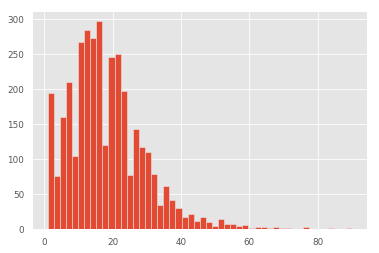

In [13]:
plt.hist([len(s) for s in list(sents)], bins=50)
plt.show()

In [14]:
max_len = 80
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}

In [15]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sents]

In [16]:
X = pad_sequences(maxlen=max_len, sequences=X, value=word2idx["PAD"], padding='post', truncating='post')

In [17]:
X[1]

array([ 6941, 12710, 18244, 11162, 12245,   747,  3612,  9813,  5586,
        6431,  1717,  7071, 15996, 12710,  7987, 15919, 15537, 10025,
       15972, 12676,  4066, 13723,  4066, 13077, 12710,  7919,  3268,
        5589,  6802,  8711, 13215,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

### Part of Speech

In [18]:
pos = list(set(x["POS_CONC"].values))
n_pos = len(pos); n_pos

276

In [19]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0
X_pos = [[pos2idx[w[1]] for w in s] for s in sents]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos[0]

array([ 70,  87, 177,  37,  55, 177,  88, 165, 253,  55,  55,  70, 184,
       177, 177,  37,  14, 171, 123,  28, 171,  88, 165,  59,  55, 262,
       232,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

### "Gold" Tags

In [20]:
tags = list(set(x["NER"].values))
n_tags = len(tags); n_tags

18

In [21]:
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [22]:
y = [[tag2idx[w[2]] for w in s] for s in sents]
y_numer = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [23]:
y_numer[1]

array([ 3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  3,  3,  8,  8,  7,  7,
        8,  8,  8,  8, 15,  8, 10,  8,  8,  8,  8,  3,  8,  8,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [24]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y_numer]
y[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
from sklearn.model_selection import train_test_split

splits = [train_test_split(X, y, X_pos, test_size=0.25, random_state=42+i) for i in range(3)]

### Prep char input

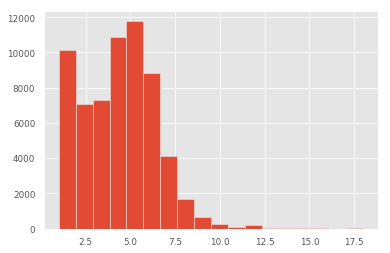

In [26]:
x.corpus_form.apply(len).hist(bins=18)

In [27]:
max_len_char = 10

In [28]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

101


In [29]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [30]:
X_char = []
for sentence in sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [31]:
splits_char = [train_test_split(X_char, y, test_size=0.25, random_state=42+i) for i in range(3)]

## Embeddings

In [32]:
embedding_paths

{'yap_w2v_sg': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt',
 'yap_w2v_cbow': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_cbow.txt',
 'yap_glove': '../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt',
 'yap_ft_sg': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec',
 'yap_ft_cbow': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_cbow.model.vec',
 'token_w2v_sg': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_skipgram.txt',
 'token_w2v_cbow': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_cbow.txt',
 'token_glove': '../wordembedding-hebrew/glove/wikipedia.tokenized.glove.txt',
 'token_ft_sg': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_skipgram.model.vec',
 'token_ft_cbow': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_cbow.model.vec',
 'pretrained_token_ft': '../fasttext/wiki.he.vec'}

In [33]:
exclude = ['cbow']

In [34]:
embedding_mats = {}
for emb_name, emb_path in embedding_paths.items():
    skip=False
    for exc in exclude:
        if exc in emb_path:
            skip=True
    if skip:
        continue
    embedding_mats[emb_name] = get_embedding_matrix(emb_path, word2idx)

loading word embeddings: ../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 7398
sample words not found:  ['הנובעות' 'הגמל' 'בידיעה' 'החשוב' 'הגושים' 'וולגארי' 'ויזכירו' 'ומואץ'
 'העידוד' 'ויופיעו']
loading word embeddings: ../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 7398
sample words not found:  ['התזקיקים' 'בסיסקו' 'שהרשויות' 'הלקוחות' 'שהשליחות' 'וכשליש' 'כשהופיעה'
 'ללקוח' 'כמבטאה' 'ההגדרה']
loading word embeddings: ../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 7398
sample words not found:  ['שיאשימו' 'הריאליזם' 'בהצהרה' 'המרי' 'במעבורת' 'החש' 'הקפדתי' 'הראשונת'
 'וחייב' 'מהקורס']
loading word embeddings: ../wordembedding-hebrew/wikipedia.tokenized.word2vec_skipgram

## Model building

In [39]:
configs = build_configs(base_configs, embedding_mats)
configs     

[{'crf': True, 'use_pos': False},
 {'crf': True, 'use_pos': True},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_w2v_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_glove',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_w2v_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_glove',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_

In [40]:
out_folder = 'outputs3'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

Train on 2349 samples, validate on 262 samples
Epoch 1/100
 - 25s - loss: 0.4073 - crf_accuracy: 0.9057 - val_loss: 0.1807 - val_crf_accuracy: 0.9625
Epoch 2/100
 - 23s - loss: 0.1509 - crf_accuracy: 0.9692 - val_loss: 0.1472 - val_crf_accuracy: 0.9662
Epoch 3/100
 - 23s - loss: 0.1137 - crf_accuracy: 0.9707 - val_loss: 0.1158 - val_crf_accuracy: 0.9691
Epoch 4/100
 - 23s - loss: 0.0846 - crf_accuracy: 0.9742 - val_loss: 0.1046 - val_crf_accuracy: 0.9736
Epoch 5/100
 - 25s - loss: 0.0659 - crf_accuracy: 0.9794 - val_loss: 0.0957 - val_crf_accuracy: 0.9749
Epoch 6/100
 - 24s - loss: 0.0514 - crf_accuracy: 0.9835 - val_loss: 0.0928 - val_crf_accuracy: 0.9763
Epoch 7/100
 - 23s - loss: 0.0391 - crf_accuracy: 0.9875 - val_loss: 0.0905 - val_crf_accuracy: 0.9781
Epoch 8/100
 - 24s - loss: 0.0285 - crf_accuracy: 0.9907 - val_loss: 0.0923 - val_crf_accuracy: 0.9741
Epoch 9/100
 - 22s - loss: 0.0195 - crf_accuracy: 0.9928 - val_loss: 0.0876 - val_crf_accuracy: 0.9778
Epoch 10/100
 - 23s - loss

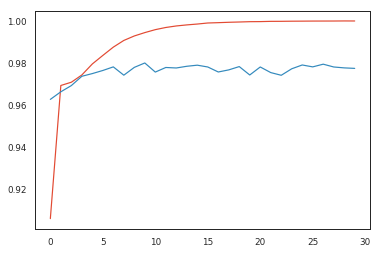

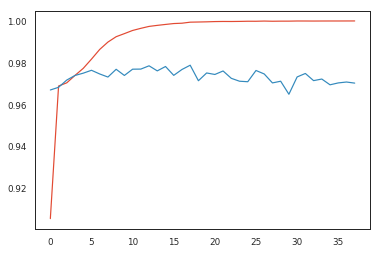

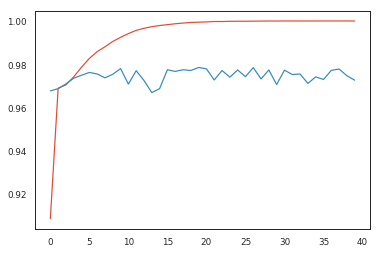

processed 15603 tokens with 1282 phrases; found: 976 phrases; correct: 537.
accuracy:  48.56%; (non-O)
accuracy:  92.48%; precision:  55.02%; recall:  41.89%; FB1:  47.56
             DATE: precision:  45.61%; recall:  25.49%; FB1:  32.70  57
              LOC: precision:  55.40%; recall:  52.20%; FB1:  53.75  278
        MISC--AFF: precision:  94.06%; recall:  56.89%; FB1:  70.90  101
        MISC--ENT: precision:   0.00%; recall:   0.00%; FB1:   0.00  6
       MISC-EVENT: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            MONEY: precision:  41.46%; recall:  36.17%; FB1:  38.64  41
              ORG: precision:  42.37%; recall:  39.37%; FB1:  40.82  236
          PERCENT: precision:  75.00%; recall:  11.11%; FB1:  19.35  8
             PERS: precision:  55.82%; recall:  42.25%; FB1:  48.10  249
             TIME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
processed 15256 tokens with 1282 phrases; found: 1263 phrases; correct: 627.
accuracy:  57.68%; (non-O)
accur

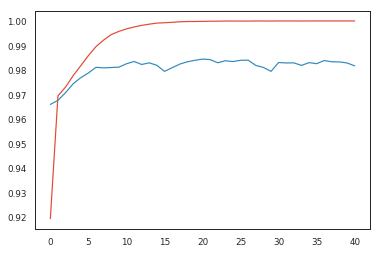

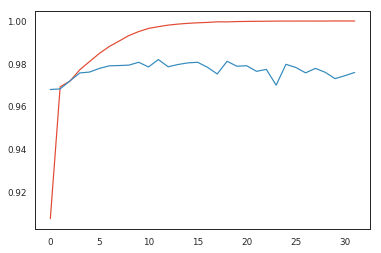

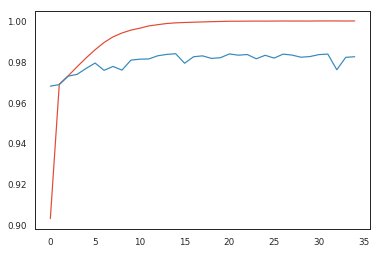

processed 15603 tokens with 1282 phrases; found: 1249 phrases; correct: 787.
accuracy:  66.89%; (non-O)
accuracy:  94.21%; precision:  63.01%; recall:  61.39%; FB1:  62.19
             DATE: precision:  58.65%; recall:  59.80%; FB1:  59.22  104
              LOC: precision:  72.29%; recall:  61.02%; FB1:  66.18  249
        MISC--AFF: precision:  86.36%; recall:  68.26%; FB1:  76.25  132
        MISC--ENT: precision:   2.04%; recall:   7.14%; FB1:   3.17  49
       MISC-EVENT: precision:  20.00%; recall:  44.44%; FB1:  27.59  20
            MONEY: precision:  75.00%; recall:  76.60%; FB1:  75.79  48
              ORG: precision:  55.51%; recall:  51.57%; FB1:  53.47  236
          PERCENT: precision:  70.45%; recall:  57.41%; FB1:  63.27  44
             PERS: precision:  63.79%; recall:  69.60%; FB1:  66.57  359
             TIME: precision:   0.00%; recall:   0.00%; FB1:   0.00  8
processed 15256 tokens with 1282 phrases; found: 1281 phrases; correct: 712.
accuracy:  60.21%; (non-O)


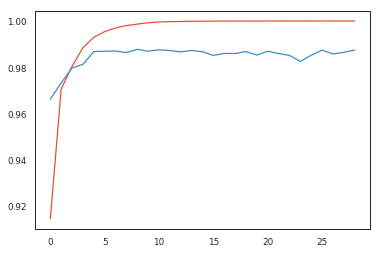

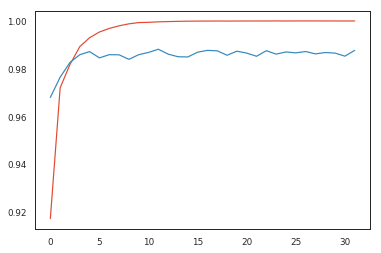

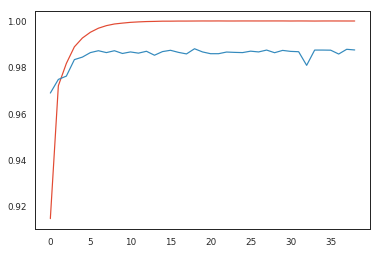

processed 15603 tokens with 1282 phrases; found: 1148 phrases; correct: 819.
accuracy:  71.52%; (non-O)
accuracy:  95.53%; precision:  71.34%; recall:  63.88%; FB1:  67.41
             DATE: precision:  77.42%; recall:  70.59%; FB1:  73.85  93
              LOC: precision:  74.70%; recall:  63.05%; FB1:  68.38  249
        MISC--AFF: precision:  93.70%; recall:  71.26%; FB1:  80.95  127
        MISC--ENT: precision:  14.29%; recall:  14.29%; FB1:  14.29  14
       MISC-EVENT: precision:  38.46%; recall:  55.56%; FB1:  45.45  13
            MONEY: precision:  72.55%; recall:  78.72%; FB1:  75.51  51
              ORG: precision:  53.39%; recall:  52.76%; FB1:  53.07  251
          PERCENT: precision:  90.48%; recall:  70.37%; FB1:  79.17  42
             PERS: precision:  74.42%; recall:  68.09%; FB1:  71.11  301
             TIME: precision:  28.57%; recall:  18.18%; FB1:  22.22  7
processed 15256 tokens with 1282 phrases; found: 1300 phrases; correct: 834.
accuracy:  74.02%; (non-O)
a

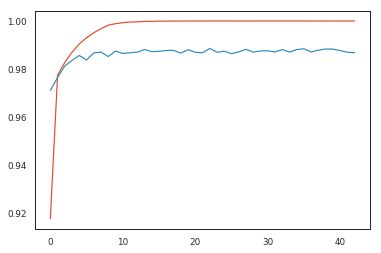

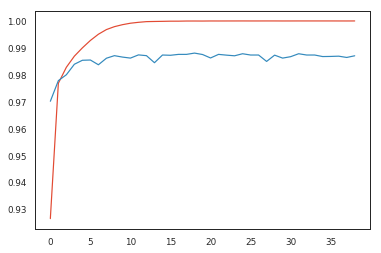

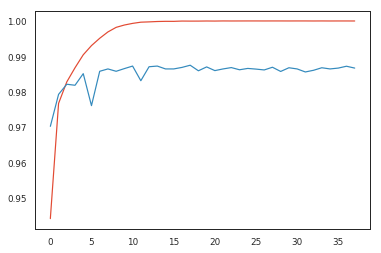

processed 15603 tokens with 1282 phrases; found: 1235 phrases; correct: 843.
accuracy:  73.48%; (non-O)
accuracy:  95.17%; precision:  68.26%; recall:  65.76%; FB1:  66.98
             DATE: precision:  69.16%; recall:  72.55%; FB1:  70.81  107
              LOC: precision:  65.28%; recall:  63.73%; FB1:  64.49  288
        MISC--AFF: precision:  89.78%; recall:  73.65%; FB1:  80.92  137
        MISC--ENT: precision:  40.00%; recall:  28.57%; FB1:  33.33  10
       MISC-EVENT: precision:  45.45%; recall:  55.56%; FB1:  50.00  11
            MONEY: precision:  75.51%; recall:  78.72%; FB1:  77.08  49
              ORG: precision:  54.81%; recall:  58.27%; FB1:  56.49  270
          PERCENT: precision:  89.36%; recall:  77.78%; FB1:  83.17  47
             PERS: precision:  70.70%; recall:  67.48%; FB1:  69.05  314
             TIME: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
processed 15256 tokens with 1282 phrases; found: 1309 phrases; correct: 845.
accuracy:  73.76%; (non-O)


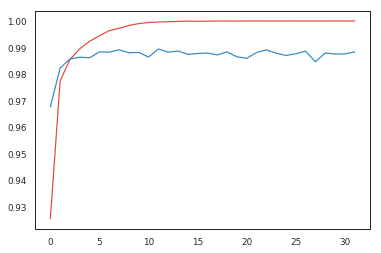

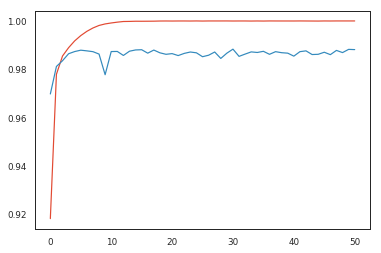

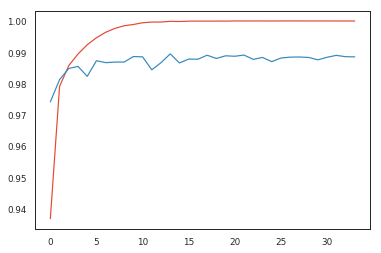

processed 15603 tokens with 1282 phrases; found: 1225 phrases; correct: 867.
accuracy:  75.33%; (non-O)
accuracy:  95.80%; precision:  70.78%; recall:  67.63%; FB1:  69.17
             DATE: precision:  69.70%; recall:  67.65%; FB1:  68.66  99
              LOC: precision:  70.89%; recall:  70.17%; FB1:  70.53  292
        MISC--AFF: precision:  86.09%; recall:  77.84%; FB1:  81.76  151
        MISC--ENT: precision:  36.36%; recall:  28.57%; FB1:  32.00  11
       MISC-EVENT: precision:  50.00%; recall:  44.44%; FB1:  47.06  8
            MONEY: precision:  84.78%; recall:  82.98%; FB1:  83.87  46
              ORG: precision:  59.29%; recall:  52.76%; FB1:  55.83  226
          PERCENT: precision:  86.96%; recall:  74.07%; FB1:  80.00  46
             PERS: precision:  70.21%; recall:  72.34%; FB1:  71.26  339
             TIME: precision:  28.57%; recall:  18.18%; FB1:  22.22  7
processed 15256 tokens with 1282 phrases; found: 1231 phrases; correct: 856.
accuracy:  72.47%; (non-O)
ac

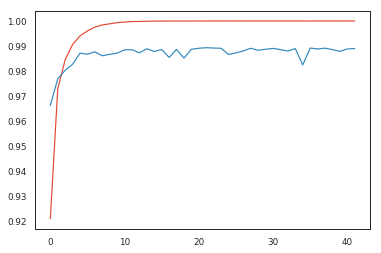

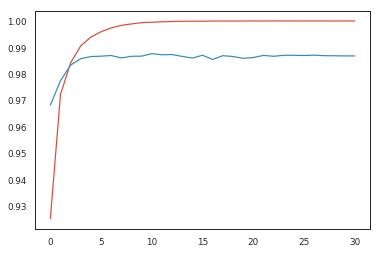

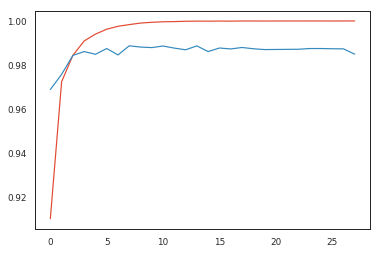

processed 15603 tokens with 1282 phrases; found: 1266 phrases; correct: 891.
accuracy:  75.90%; (non-O)
accuracy:  95.82%; precision:  70.38%; recall:  69.50%; FB1:  69.94
             DATE: precision:  67.57%; recall:  73.53%; FB1:  70.42  111
              LOC: precision:  69.00%; recall:  70.17%; FB1:  69.58  300
        MISC--AFF: precision:  87.66%; recall:  80.84%; FB1:  84.11  154
        MISC--ENT: precision:  18.52%; recall:  35.71%; FB1:  24.39  27
       MISC-EVENT: precision:  38.46%; recall:  55.56%; FB1:  45.45  13
            MONEY: precision:  78.00%; recall:  82.98%; FB1:  80.41  50
              ORG: precision:  63.52%; recall:  58.27%; FB1:  60.78  233
          PERCENT: precision:  89.19%; recall:  61.11%; FB1:  72.53  37
             PERS: precision:  73.33%; recall:  73.56%; FB1:  73.44  330
             TIME: precision:  18.18%; recall:  18.18%; FB1:  18.18  11
processed 15256 tokens with 1282 phrases; found: 1151 phrases; correct: 782.
accuracy:  68.97%; (non-O)

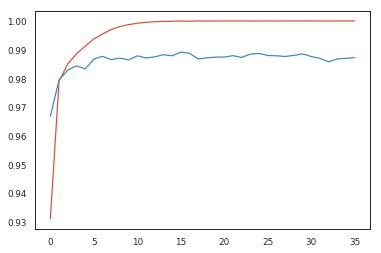

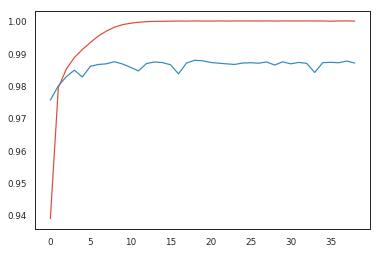

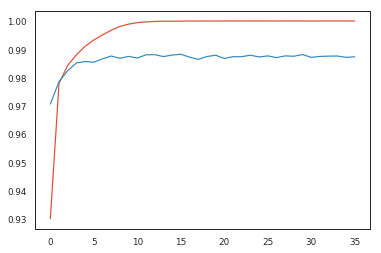

processed 15603 tokens with 1282 phrases; found: 1213 phrases; correct: 851.
accuracy:  75.95%; (non-O)
accuracy:  95.64%; precision:  70.16%; recall:  66.38%; FB1:  68.22
             DATE: precision:  68.63%; recall:  68.63%; FB1:  68.63  102
              LOC: precision:  72.16%; recall:  66.78%; FB1:  69.37  273
        MISC--AFF: precision:  90.77%; recall:  70.66%; FB1:  79.46  130
        MISC--ENT: precision:  33.33%; recall:  21.43%; FB1:  26.09  9
       MISC-EVENT: precision:  38.46%; recall:  55.56%; FB1:  45.45  13
            MONEY: precision:  83.33%; recall:  85.11%; FB1:  84.21  48
              ORG: precision:  62.17%; recall:  56.30%; FB1:  59.09  230
          PERCENT: precision:  68.85%; recall:  77.78%; FB1:  73.04  61
             PERS: precision:  67.35%; recall:  69.60%; FB1:  68.46  340
             TIME: precision:  57.14%; recall:  36.36%; FB1:  44.44  7
processed 15256 tokens with 1282 phrases; found: 1308 phrases; correct: 871.
accuracy:  76.96%; (non-O)
a

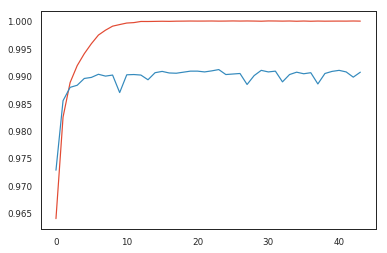

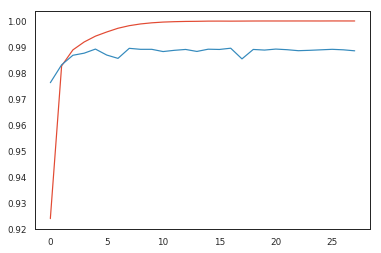

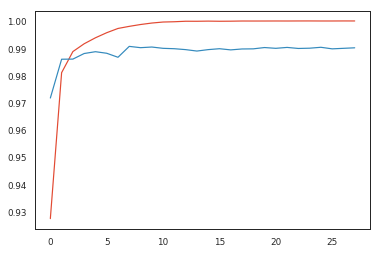

processed 15603 tokens with 1282 phrases; found: 1309 phrases; correct: 964.
accuracy:  81.31%; (non-O)
accuracy:  96.44%; precision:  73.64%; recall:  75.20%; FB1:  74.41
             DATE: precision:  73.58%; recall:  76.47%; FB1:  75.00  106
              LOC: precision:  73.20%; recall:  75.93%; FB1:  74.54  306
        MISC--AFF: precision:  85.53%; recall:  81.44%; FB1:  83.44  159
        MISC--ENT: precision:  36.36%; recall:  28.57%; FB1:  32.00  11
       MISC-EVENT: precision:  43.75%; recall:  77.78%; FB1:  56.00  16
            MONEY: precision:  83.02%; recall:  93.62%; FB1:  88.00  53
              ORG: precision:  60.85%; recall:  67.32%; FB1:  63.93  281
          PERCENT: precision:  89.13%; recall:  75.93%; FB1:  82.00  46
             PERS: precision:  78.53%; recall:  77.81%; FB1:  78.17  326
             TIME: precision:  60.00%; recall:  27.27%; FB1:  37.50  5
processed 15256 tokens with 1282 phrases; found: 1280 phrases; correct: 929.
accuracy:  80.52%; (non-O)


In [ ]:
configs, results, preds, histories = run_models(configs, splits, splits_char, embedding_mats, 
                                                words, max_len, n_words, idx2word, idx2tag,
                                                n_tags, max_len_char, n_pos, n_chars,
                                                run_name='naama_token', out_folder=out_folder,
                                                skip_if_model_exists=True)

In [ ]:
results

In [ ]:
for c in configs:
    if 'embedding_matrix' in c:
        c.update({'embedding_matrix': 'fastext'}) 

In [47]:
defaults = {'use_word': True, 'use_pos': False, 'embedding_matrix': None, 
            'embed_dim': 70, 'trainable': True, 'input_dropout': False, 
            'stack_lstm': 1, 'epochs': 100, 'early_stopping': True, 'patience': 20, 
            'min_delta': 0.0001, 'use_char': False, 'crf': False, 'stack_cross': False, 
            'stack_double': False, 'rec_dropout': 0.1}

In [48]:
for conf in configs:
    conf.update({'use_morpheme': True})
    conf.update({'use_word': False})

    for key in defaults:
        if key not in conf:
            conf[key] = defaults[key]

In [ ]:
len(list(zip(configs, results, preds, histories)))

In [52]:
def get_results_df(configs, results):
    dict_res = []
    for conf, res in zip(configs, results):
        dr = {}
        for i, r in enumerate(res):
            split_name = chr(ord('a')+i)
            dr['prec_'+split_name], dr['recall_'+split_name], dr['f1_'+split_name] = r
        dr.update(conf)
        dict_res.append(dr)
    rdf = (pd.DataFrame(dict_res)
           .assign(prec = lambda x: (x.prec_a + x.prec_b + x.prec_c)/3)
           .assign(recall = lambda x: (x.recall_a + x.recall_b + x.recall_c)/3)
           .assign(f1 = lambda x: (x.f1_a + x.f1_b + x.f1_c)/3))
    return rdf

In [53]:
res1 = pickle.load(open('treebank_results_1.pkl', 'rb'))

In [54]:
res2 = pickle.load(open('treebank_results_2_test25.pkl', 'rb'))

In [57]:
rdf1 = get_results_df([c for c, r, h in res1], [r for c, r, h in res1])

In [58]:
rdf2 = get_results_df([c for c, r, p, h in res2], [r for c, r, p, h in res2])

In [60]:
rdf2.head()

,crf,early_stopping,embed_dim,embedding_matrix,epochs,f1_a,f1_b,f1_c,input_dropout,min_delta,...,stack_double,stack_lstm,trainable,use_char,use_morpheme,use_pos,use_word,prec,recall,f1
0,True,True,70,None,100,61.595231,64.524986,63.937419,False,0.0001,...,False,1,True,False,True,False,False,66.866298,60.221498,63.352545
1,True,True,70,None,100,72.074967,71.615721,72.101911,False,0.0001,...,False,1,True,False,True,True,False,73.574440,70.383441,71.930866
2,True,True,300,fastext,100,77.924131,76.407437,77.421053,False,0.0001,...,False,1,True,False,True,False,False,78.371539,76.234033,77.250873
3,True,True,300,fastext,100,80.941052,79.862215,80.050761,False,0.0001,...,False,1,True,False,True,True,False,80.810288,79.768234,80.284676
4,True,True,70,None,100,69.732492,67.697498,70.299037,False,0.0001,...,False,1,True,True,True,False,False,74.882658,64.751970,69.243009


In [61]:
 (rdf2.fillna('No')
 .groupby(['use_char', 'use_pos', 'embedding_matrix'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[0,1])
 .round(1)
 )

use_char         False       True       
use_pos          False True  False True 
embedding_matrix                        
No                63.4  71.9  69.2  75.0
fastext           77.3  80.3  82.0  83.3

In [63]:
 (rdf1.fillna('No')
 .groupby(['use_char', 'use_pos', 'embedding_matrix'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[0,1])
 .round(1)
 )

use_char         False       True       
use_pos          False True  False True 
embedding_matrix                        
No                67.9  74.4  70.7  75.8
fastext           79.4  83.4  82.9  84.6